### Put uncompressed data in a CSV

In [52]:
import numpy as np
import xarray as xr
import pandas as pd

# Step 1: Function to parse .hdr file metadata with adjusted split logic
def parse_hdr_file(hdr_path):
    with open(hdr_path, 'r') as hdr_file:
        hdr_lines = hdr_file.readlines()
    
    metadata = {}
    for line in hdr_lines:
        if '=' in line:
            key, value = line.split('=', 1)
            metadata[key.strip()] = value.strip()
    
    samples = int(metadata['samples'])
    lines = int(metadata['lines'])
    bands = int(metadata['bands'])
    dtype_map = {'4': np.float32, '12': np.int16}
    dtype = dtype_map[metadata['data type']]
    
    return samples, lines, bands, dtype

# Step 2: Load binary data as xarray DataArray
def load_binary_as_xarray(bin_path, samples, lines, bands, dtype):
    data = np.fromfile(bin_path, dtype=dtype).reshape((lines, samples, bands))
    data_array = xr.DataArray(data, dims=("lines", "samples", "band"))
    return data_array

# Step 3: Generate bit information for each band (simulating xbitinfo behavior for example purposes)
def compute_bit_information(data_array):
    # Assuming each band has 32 bits of information
    num_bands = data_array.sizes["band"]
    bit_info = xr.DataArray(
        np.random.rand(num_bands, 32),  # Simulating 32-bit information for each band
        dims=["band", "bit32"]
    )
    return bit_info

# Step 4: Structure bit information for CSV output
def compute_and_structure_bit_information(data_array):
    bit_info = compute_bit_information(data_array)
    
    # Check dimensions to confirm alignment
    if "band" not in bit_info.dims:
        raise ValueError("Expected 'band' dimension in bit_info")
    if bit_info.sizes["bit32"] != 32:
        raise ValueError("Expected 32 bits in 'bit32' dimension of bit_info")

    # Structure the bit information by bands for CSV
    bit_info_rows = []
    for band in range(data_array.sizes["band"]):
        bit_data = bit_info.sel(band=band).values  # Correctly select based on band
        if len(bit_data) != 32:
            raise ValueError(f"Unexpected bit_data length for band {band}: {len(bit_data)}")
        
        # Construct a row for each band
        bit_info_rows.append({
            "band": band,
            **{f"bit{i+1}": bit_data[i] for i in range(32)}
        })
    
    bit_info_df = pd.DataFrame(bit_info_rows)
    return bit_info_df

# Step 5: Save the bit information to CSV
def save_bit_information_to_csv(bit_info_df, filename):
    bit_info_df.to_csv(filename, index=False)

# Step 6: Running the process
hdr_path = "/Users/kitlewers/Desktop/naive_compression/imagery/ang20231109t092617_027_L2A_OE_main_27577724_RFL_ORT.hdr"
bin_path = "/Users/kitlewers/Desktop/naive_compression/imagery/ang20231109t092617_027_L2A_OE_main_27577724_RFL_ORT"

# Load metadata
samples, lines, bands, dtype = parse_hdr_file(hdr_path)

# Load data as xarray DataArray
data_array = load_binary_as_xarray(bin_path, samples, lines, bands, dtype)

# Compute and structure bit information
bit_info_df = compute_and_structure_bit_information(data_array)

# Save to CSV
save_bit_information_to_csv(bit_info_df, "bit_information_by_band.csv")


### Visualize bits of uncompressed data

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4y/vdf6lk8d18qf_nvdqb40_nfw0000gn/T/ipykernel_22598/2377013395.py:16: SyntaxWarning: invalid escape sequence '\d'
  bit_info_long["bit"] = bit_info_long["bit"].str.extract('(\d+)').astype(int)


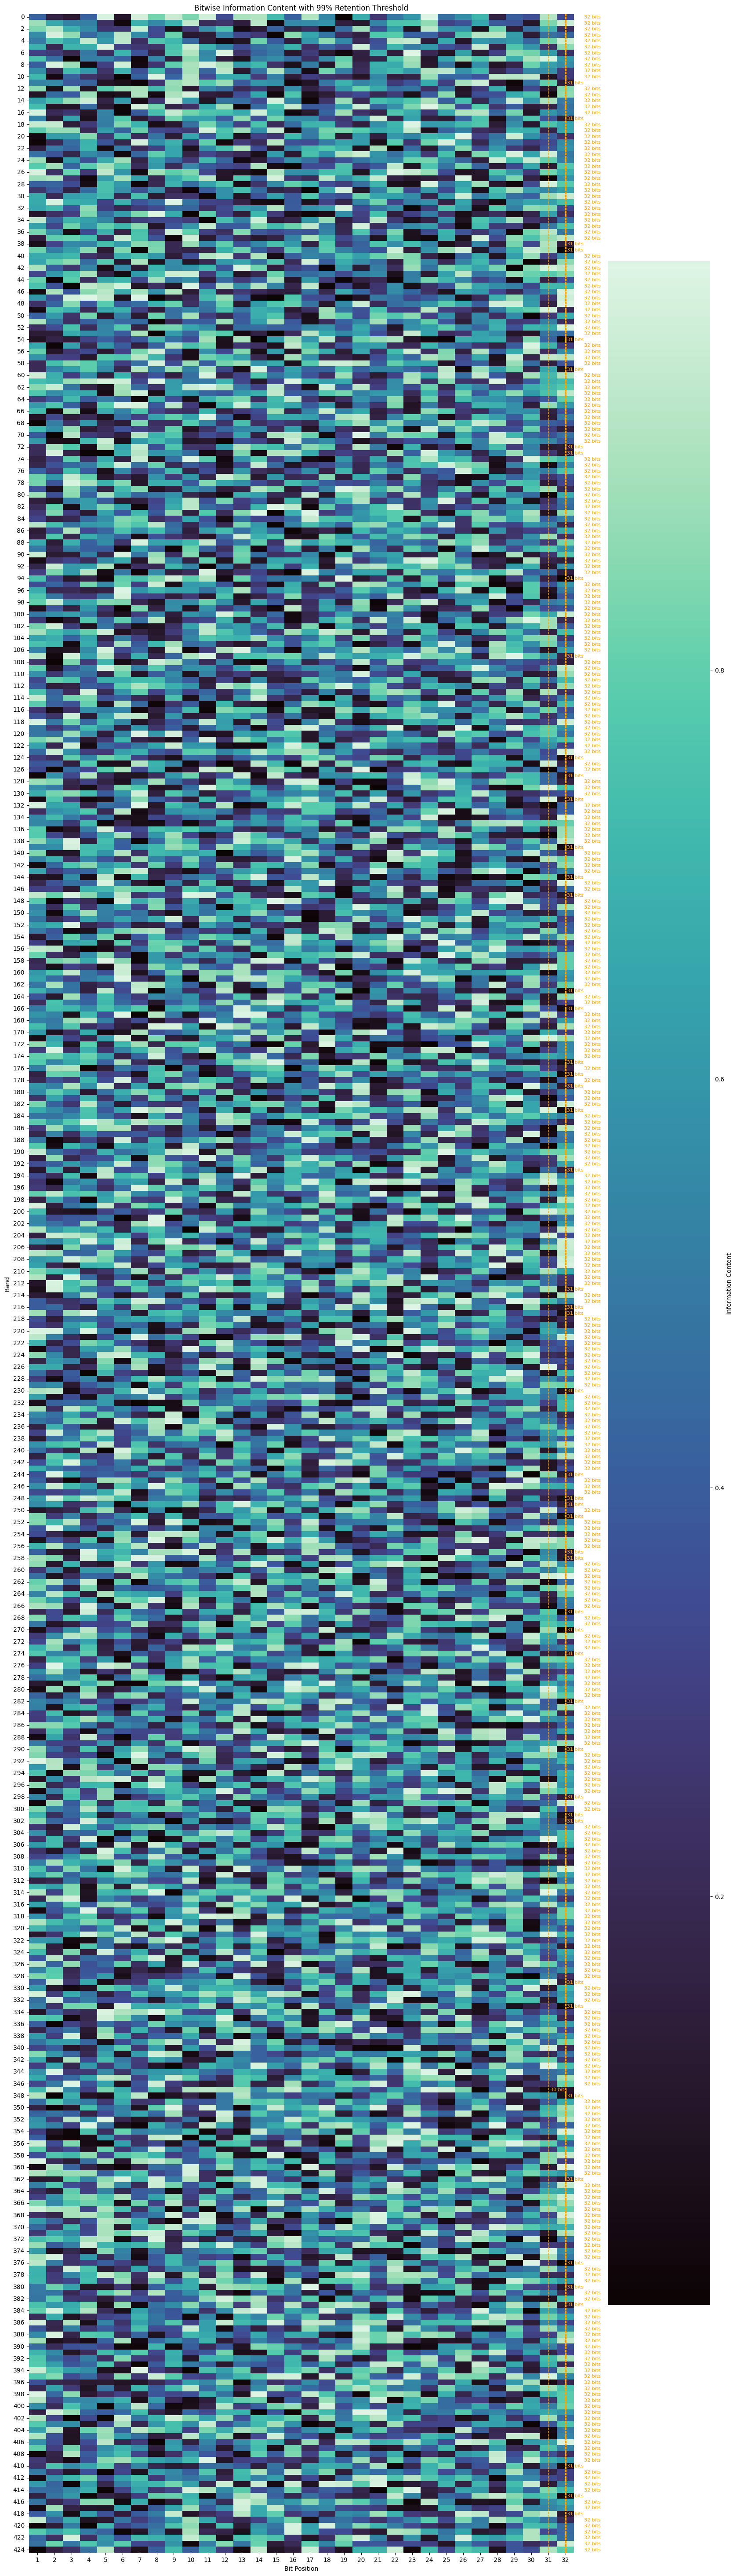

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load CSV data
csv_path = "/Users/kitlewers/Desktop/naive_compression/code/bit_information_by_band.csv"  # replace with actual path
bit_info_df = pd.read_csv(csv_path)

# Step 2: Prepare data for plotting
# Melt the dataframe to have 'band' and 'bit' columns
bit_info_long = bit_info_df.melt(id_vars=["band"], 
                                 var_name="bit", 
                                 value_name="information_content")

# Convert bit columns to integers (e.g., 'bit1' -> 1, 'bit2' -> 2, etc.)
bit_info_long["bit"] = bit_info_long["bit"].str.extract('(\d+)').astype(int)

# Step 3: Calculate cumulative information for each band to find 99% cutoff
bit_info_long = bit_info_long.sort_values(["band", "bit"])  # Ensure data is sorted
bit_info_long["cumulative_info"] = bit_info_long.groupby("band")["information_content"].cumsum()
bit_info_long["total_info"] = bit_info_long.groupby("band")["information_content"].transform("sum")
bit_info_long["percent_info"] = bit_info_long["cumulative_info"] / bit_info_long["total_info"]

# Find the bit position where cumulative information content first exceeds 99%
threshold_data = bit_info_long[bit_info_long["percent_info"] >= 0.99].drop_duplicates("band")
threshold_data = threshold_data.set_index("band")["bit"]

# Step 4: Pivot data for heatmap plotting
heatmap_data = bit_info_long.pivot(index="band", columns="bit", values="information_content")

# Step 5: Custom colormap and plot the heatmap
cmap = sns.color_palette("mako", as_cmap=True)
plt.figure(figsize=(20, 75))
sns.heatmap(heatmap_data, cmap=cmap, cbar_kws={'label': 'Information Content'})

# Step 6: Overlay the 99% information threshold as vertical lines for each band
for band, bit_cutoff in threshold_data.items():
    plt.axvline(bit_cutoff + 0.5, color='orange', linestyle="--", linewidth=1)  # Vertical line at the threshold bit
    plt.text(bit_cutoff + 0.6, band + 0.5, f"{bit_cutoff} bits", color="orange", ha="left", va="center", fontsize=8)

# Customize the plot to resemble the original paper's style
plt.xlabel("Bit Position")
plt.ylabel("Band")
plt.title("Bitwise Information Content with 99% Retention Threshold")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


### X-Bit Info Compression

In [57]:
import xarray as xr
import numpy as np
import pandas as pd
import xbitinfo
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio

# Step 1: Load your hyperspectral data
# Replace 'your_binary_file' and 'your_hdr_file' with your actual file paths
hdr_file_path = '/Users/kitlewers/Desktop/naive_compression/imagery/ang20231109t092617_027_L2A_OE_main_27577724_RFL_ORT.hdr'
binary_file_path = '/Users/kitlewers/Desktop/naive_compression/imagery/ang20231109t092617_027_L2A_OE_main_27577724_RFL_ORT'

# Load the binary file using the metadata from the .hdr file
# Adjust this part as needed based on how you load the data from ENVI format
data = xr.open_dataset(binary_file_path, engine="rasterio")  # Customize as per your data

# Step 2: Apply xbitinfo compression with a 99% information retention threshold
bitinfo = xbitinfo.BitInfo(data)
bitinfo = bitinfo.fit(threshold=0.99)  # Retain 99% of information
compressed_data = bitinfo.transform(data)  # Transform to compressed form

# Step 3: Extract bitwise information content and save to CSV
info_df = pd.DataFrame(bitinfo.information_content_, columns=[f"bit{i+1}" for i in range(bitinfo.information_content_.shape[1])])
info_df['band'] = range(len(info_df))  # Add band identifier
info_df.to_csv("bitwise_information_content.csv", index=False)  # Save to CSV
print("CSV file generated: bitwise_information_content.csv")

# Step 4: Load the CSV and prepare for plotting
data = pd.read_csv("bitwise_information_content.csv")

# Drop the 'band' column for visualization and calculate cumulative information content
bit_data = data.drop(columns=["band"])
cumulative_info = bit_data.cumsum(axis=1) / bit_data.sum(axis=1)[:, np.newaxis]

# Find the 99% threshold for each band
threshold_lines = (cumulative_info >= 0.99).idxmax(axis=1).astype(int)

# Step 5: Plotting the Information Retention Heatmap
plt.figure(figsize=(20, 80))
sns.heatmap(bit_data, cmap="viridis", cbar_kws={'label': 'Information Content'}, xticklabels=range(1, 33))
plt.xlabel("Bit Position")
plt.ylabel("Band")
plt.title("Bitwise Information Content Across Bands")

# Plot horizontal dashed lines at the 99% retention level for each band
for i, bit_position in enumerate(threshold_lines):
    plt.hlines(y=i, xmin=0, xmax=bit_position, colors='red', linestyles='dashed', linewidth=0.5)

plt.show()


DEBUG (22598) exception occured? 10937000976
DEBUG:julia:exception occured? 10937000976
DEBUG (22598) exception occured? None
DEBUG:julia:exception occured? None


ValueError: unrecognized engine rasterio must be one of your download engines: ['netcdf4', 'scipy', 'store']To install additional dependencies, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html